# Annotating images Using labelMe

In [ ]:
!labelme

# Resize Images if images with different sizes only

In [1]:
import PIL
import os
import os.path
from PIL import Image


path = 'data/originalImages'
for file in os.listdir(path): 
    f_img = path+"/"+file
    img = Image.open(f_img)

    img = img.resize((750, 469)) #(width, height)
    s_path = 'data/images/'+file
    img.save(s_path)

# 2 Building Image Loading Function

### 2.1 Importing TF Dependencies 

In [11]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [13]:
images = tf.data.Dataset.list_files('data\\images\\*.jpeg', shuffle=True)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpeg'

In [12]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [15]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [11]:
images.as_numpy_iterator().next()
# type(images)

NameError: name 'images' is not defined

In [31]:
images_generator = images.batch(4).as_numpy_iterator()

In [32]:
plot_images = images_generator.next()

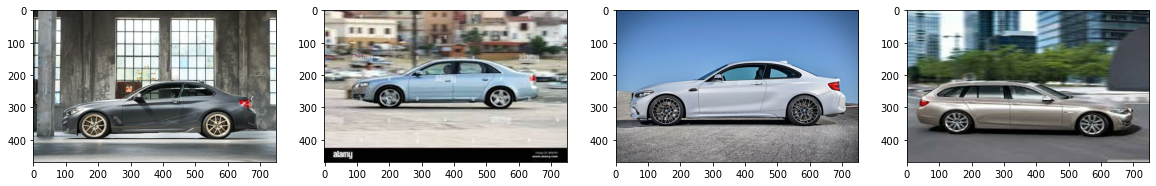

In [33]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

### divide imageset into train, test and val

##### train = total * 0.7 = 87
##### test = total * 0.15 = 18
##### val = total * 0.15 = 18

### Moving labels to train, test & val folders

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels',filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 3. Image Augmentation

In [29]:
import albumentations as alb
import cv2

### 3.1 One image demonstration

In [63]:
augmentor = alb.Compose([alb.RandomCrop(width=460, height=460),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                    bbox_params= alb.BboxParams(format='albumentations',
                        label_fields=['class_labels']))

In [64]:
img = cv2.imread(os.path.join('data','train','images','0a409f4c-e3d0-46b9-b889-9f58d090a051.jpeg'))

In [65]:
with open(os.path.join('data','train','labels','0a409f4c-e3d0-46b9-b889-9f58d090a051.json'), 'r') as f:
    label = json.load(f)

In [66]:
label['shapes']

[{'label': 'side-view',
  'points': [[426.02702702702703, 265.64864864864865],
   [485.4864864864865, 369.7027027027027]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

### 3.2 Extract Coordinates 

In [67]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

coords

[426.02702702702703, 265.64864864864865, 485.4864864864865, 369.7027027027027]

In [68]:
coords = list(np.divide(coords, [750,469,750,469]))

In [69]:
coords

[0.568036036036036, 0.5664150291015962, 0.6473153153153154, 0.8037015276145711]

In [70]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])

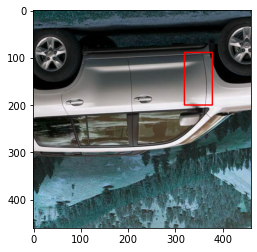

In [74]:
cv2.rectangle(augmented['image'],
                tuple(np.multiply(augmented['bboxes'][0][:2],[460,460]).astype(int)), # top coordinate
                tuple(np.multiply(augmented['bboxes'][0][2:],[460,460]).astype(int)), # bottom coordinate
                (250,0,0),2) # color and thinkness of rectangle 

plt.imshow(augmented['image'])

### 3.3 Transforming all images

In [81]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data',partition,'images')):
        img = cv2.imread(os.path.join('data',partition, 'images', image ))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data',partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [750,469,750,469]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['side-view'])
                cv2.imwrite(os.path.join('data','aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpeg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('data','aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

### 3.4 Loading Transformed images

In [13]:
train_images = tf.data.Dataset.list_files('data\\aug_data\\train\\images\\*.jpeg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x , (120,120)))
train_images = train_images.map(lambda x: x/255)

In [14]:
test_images = tf.data.Dataset.list_files('data\\aug_data\\test\\images\\*.jpeg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x , (120,120)))
test_images = test_images.map(lambda x: x/255)

In [15]:
val_images = tf.data.Dataset.list_files('data\\aug_data\\val\\images\\*.jpeg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x , (120,120)))
val_images = val_images.map(lambda x: x/255)

## 4. Prepare Labels

In [16]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [17]:
train_labels = tf.data.Dataset.list_files('data\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [18]:
test_labels = tf.data.Dataset.list_files('data\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [19]:
val_labels = tf.data.Dataset.list_files('data\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 5. Combine Labels with images

#### 5.1 Check partition lenght

In [20]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5220, 5220, 1080, 1080, 1080, 1080)

#### 5.2 Final Dataset creation (Images/Labels)

In [21]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [23]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [24]:
train.as_numpy_iterator().next()

(array([[[[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00]],
 
         [[1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          ...,
          [1.0000000e+00, 1.0000000e+00, 1.0000000e+00],
          [1.0000000e+00, 1.0000000e+

### 5.3 Viewing images with annotations

In [25]:
data_samples = train.as_numpy_iterator()

In [26]:
res = data_samples.next()

NameError: name 'cv2' is not defined

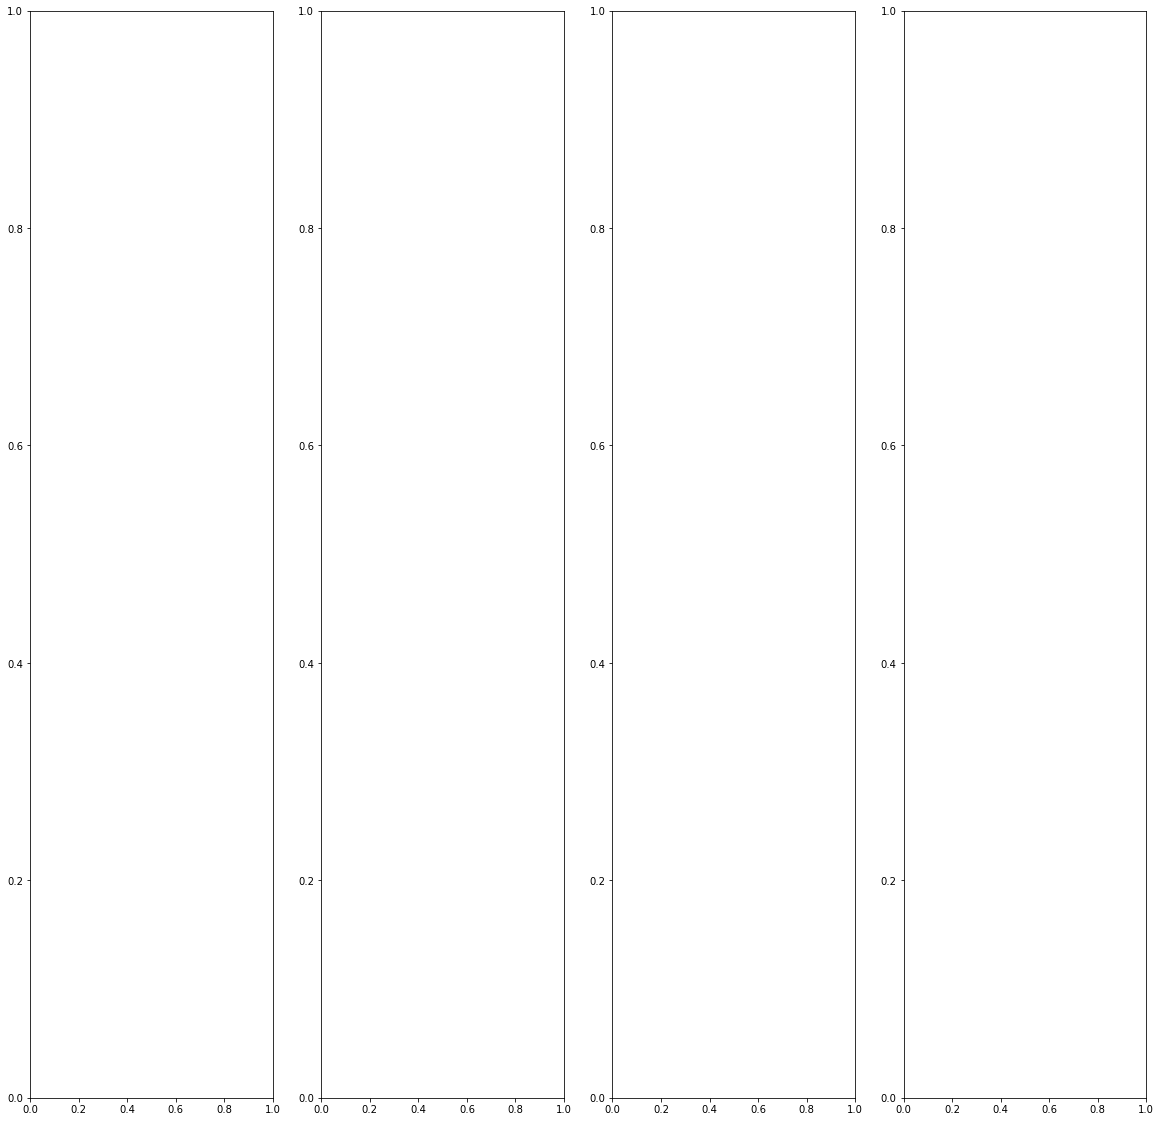

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                (255,0,0), 2)
    ax[idx].imshow(sample_image)

# 6 Deep Learning model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Add, GlobalMaxPooling2D, Dropout, ReLU
from tensorflow.keras.applications import VGG16

### 6.1 Download VGG16
![alt text](vgg16_img.png "VGG16 Structure")

In [ ]:
vgg = VGG16(include_top=False) #download 

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 6.2 Adding layers to VGG16

In [ ]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    ROIExtractor = Model(inputs=input_layer, outputs=[class2, regress2])
    return ROIExtractor

In [28]:
ROIExtractorModel = build_model()

In [29]:
ROIExtractorModel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [30]:
X, y = train.as_numpy_iterator().next()

In [31]:
X

array([[[[0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         ...,
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ]],

        [[0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         ...,
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ]],

        [[0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         ...,
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ],
         [0.98039216, 0.9607843 , 0.9490196 ]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]

In [32]:
classes, coords = ROIExtractorModel.predict(X)

1/1 [==============================] - 0s 434ms/step


In [33]:
classes, coords

(array([[0.5133178 ],
        [0.51084113],
        [0.5404441 ],
        [0.5374154 ],
        [0.5544065 ],
        [0.39924923],
        [0.5023121 ],
        [0.44452125]], dtype=float32),
 array([[0.4307838 , 0.42077026, 0.5558002 , 0.41551644],
        [0.47857434, 0.48132777, 0.61332154, 0.40684098],
        [0.413983  , 0.56339866, 0.52995116, 0.4160087 ],
        [0.47601148, 0.41993833, 0.6268534 , 0.47091776],
        [0.47047144, 0.41898894, 0.6447386 , 0.5125969 ],
        [0.46015102, 0.41948333, 0.6160236 , 0.42036933],
        [0.509929  , 0.44223544, 0.635333  , 0.4192409 ],
        [0.4549167 , 0.4537028 , 0.5986218 , 0.43530783]], dtype=float32))

# 7 Defining Loss Function & Optimizer 

In [34]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

#### 7.1 Creating Localization Loss and Classification Loss

In [36]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [37]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [38]:
localization_loss(y[1], coords).numpy()

1.893656

In [39]:
classloss(y[0], classes).numpy()

0.703199

In [40]:
regressloss(y[1], coords).numpy()

1.893656

# 8. Train Neural Network

#### 8.1 Creating Custom model class

In [41]:
class ROIExtractor(Model):
    def __init__(self, ROIExtractor, **kwargs):
        super().__init__(**kwargs)
        self.model = ROIExtractor

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt 
    
    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=True)

        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_localizationloss+0.5*batch_classloss

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [42]:
model = ROIExtractor(ROIExtractorModel)

In [43]:
model.compile(opt, classloss, regressloss)

#### 8.2 Train

In [44]:
logdir = 'logs'

In [45]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [46]:
hist = model.fit(train.take(100), epochs=100, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/100
100/100 [==============================] - 143s 1s/step - total_loss: 1.1128 - class_loss: 0.2841 - regress_loss: 0.9708 - val_total_loss: 1.7892 - val_class_loss: 1.0113 - val_regress_loss: 1.2836
Epoch 2/100
100/100 [==============================] - 140s 1s/step - total_loss: 0.7858 - class_loss: 0.2976 - regress_loss: 0.6370 - val_total_loss: 0.6465 - val_class_loss: 0.4275 - val_regress_loss: 0.4328
Epoch 3/100
100/100 [==============================] - 141s 1s/step - total_loss: 0.4725 - class_loss: 0.1998 - regress_loss: 0.3726 - val_total_loss: 0.2263 - val_class_loss: 0.0109 - val_regress_loss: 0.2208
Epoch 4/100
100/100 [==============================] - 139s 1s/step - total_loss: 0.4264 - class_loss: 0.1584 - regress_loss: 0.3472 - val_total_loss: 0.3975 - val_class_loss: 0.1080 - val_regress_loss: 0.3434
Epoch 5/100
100/100 [==============================] - 139s 1s/step - total_loss: 0.3376 - class_loss: 0.1207 - regress_loss: 0.2772 - val_total_loss: 0.4260 - 

In [99]:
hist.history

{'total_loss': [0.6189196705818176,
  1.0004879236221313,
  0.13283215463161469,
  0.6760873794555664,
  0.18835632503032684,
  0.06337040662765503,
  0.029556062072515488,
  0.07817494869232178,
  0.06935666501522064,
  0.11056883633136749,
  0.11189725250005722,
  0.07147200405597687,
  0.038213133811950684,
  0.008370514027774334,
  0.02399524673819542,
  0.1365659236907959,
  0.022513899952173233,
  0.14173395931720734,
  0.00992185901850462,
  0.00968597736209631,
  0.03622187674045563,
  0.09953399002552032,
  0.05251530185341835,
  0.03317425027489662,
  0.05501870810985565,
  0.013661017641425133,
  0.16377365589141846,
  0.021693900227546692,
  0.012813731096684933,
  0.017228396609425545,
  0.006242647767066956,
  0.014548884704709053,
  0.014292617328464985,
  0.029341766610741615,
  0.005743077024817467,
  0.005136415362358093,
  0.03284851461648941,
  0.005500852130353451,
  0.006426235195249319,
  0.01587274670600891,
  0.09168462455272675,
  0.29215729236602783,
  0.0456

#### 8.3 Plot Graph

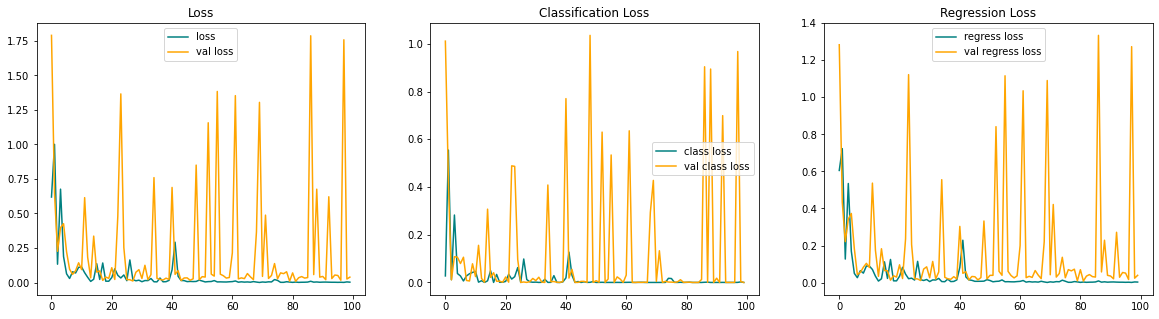

In [100]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 9. Making Predictions

In [180]:
import cv2

In [181]:
test_data = test.as_numpy_iterator()

In [182]:
test_sample = test_data.next()

In [183]:
yhat = ROIExtractorModel.predict(test_sample[0])

1/1 [==============================] - 0s 274ms/step


In [184]:
yhat[0]

array([[0.9989674 ],
       [0.9999991 ],
       [1.        ],
       [0.0029001 ],
       [0.9999999 ],
       [1.        ],
       [0.99999887],
       [0.9999994 ]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


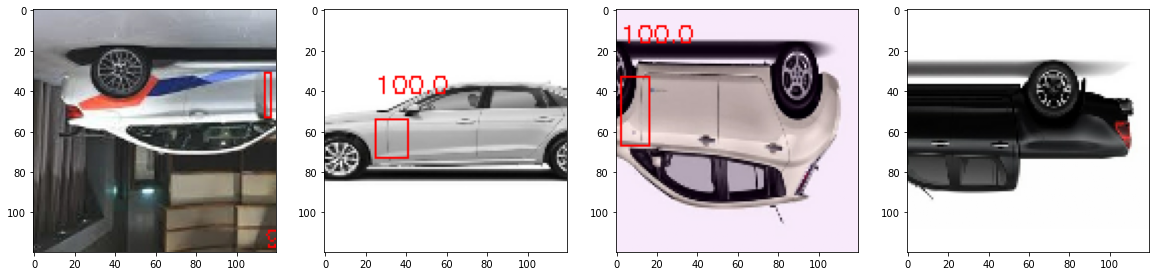

In [185]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                (255,0,0), 1)
        cv2.putText(sample_image,
                str(round(float(yhat[0][idx]) * 100, 2)),
                (int(np.multiply(sample_coords[0], [120])),int(np.multiply(sample_coords[2], [120]))),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0), 1)
    ax[idx].imshow(sample_image)

#### 9.1 Saving Model

In [186]:
from tensorflow.keras.models import load_model

In [187]:
ROIExtractorModel.save('ROIExtractorModel.h5')